In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModelTimeStep
from deep_macrofin import ActivationType, LayerType, OptimizerType, SamplingMethod, plot_loss_df, set_seeds

In [2]:
n_tree = 3
params = {
    "gamma": 5,
    "rho": 0.05,
    "mu_ys": torch.tensor([0.01 * (i+1) for i in range(n_tree)]).unsqueeze(0),
    "sig_ys": torch.tensor([0.01 * (i+1) for i in range(n_tree)]).unsqueeze(0),
}
base_model_dir =f"./models/tree_{n_tree}_tsbatched_sym"

In [3]:
def compute_q(SV, compute_k):
    z = SV[..., :-1]
    z_last = 1 - torch.sum(z, dim=-1).unsqueeze(-1)
    z_all = torch.cat([z, z_last], dim=-1) # (B, N)
    return z_all / compute_k(SV)

def compute_qz(SV, compute_k):
    return torch.vmap(torch.func.jacrev(lambda SV: compute_q(SV, compute_k)))(SV)[:, :, :-1]

def compute_qzz(SV, compute_k):
    return torch.vmap(torch.func.hessian(lambda SV: compute_q(SV, compute_k)))(SV)[:,:,:-1,:-1]

def compute_mu_z_geos(z_all, mu_ys, sig_ys):
    return (
            mu_ys[:, :-1] 
            - torch.sum(mu_ys * z_all, dim=1, keepdim=True) 
            + torch.sum(sig_ys * z_all, dim=1, keepdim=True) 
                * (torch.sum(sig_ys * z_all, dim=1, keepdim=True) - sig_ys[:, :-1])
        )
def compute_sig_z_geos(z_all, sig_ys):
    return (
            sig_ys[:, :-1]
            - torch.sum(sig_ys * z_all, dim=1, keepdim=True)
        )

def compute_mu_qs(q, dq_dz, dq_dzz, mu_z_aris, sig_z_aris):
    return (torch.einsum("bnj, bj -> bn", dq_dz, mu_z_aris)
            + 0.5 * torch.einsum("bj, bnjk, bk -> bn", sig_z_aris, dq_dzz, sig_z_aris)
        ) / q

def compute_sig_qs(q, dq_dz, sig_z_aris):
    return torch.einsum("bnj, bj -> bn", dq_dz, sig_z_aris) / q

def compute_r(rho, gamma, mu_ys, sig_ys, z, z_last):
    return (rho + gamma * (torch.sum(mu_ys[:, :-1] * z, dim=1, keepdim=True) + mu_ys[:, -1:] * z_last)
        - 0.5 * gamma * (gamma + 1) * (torch.sum(sig_ys[:, :-1]**2 * z**2, dim=1, keepdim=True) + sig_ys[:, -1:]**2 * z_last**2)
        )

def compute_hjb_kappa(kappa, dkappa_dt, dkappa_dz, dkappa_dzz, mu_z_aris, sig_z_aris, mu_kappas):
    return torch.sum(dkappa_dt + torch.einsum("bnj, bj -> bn", dkappa_dz, mu_z_aris)
            + 0.5 * torch.einsum("bj, bnjk, bk -> bn", sig_z_aris, dkappa_dzz, sig_z_aris)
            - torch.einsum("bn, bn -> bn", mu_kappas, kappa), dim=1, keepdim=True
        )

def compute_kappa_penalization(kappas):
    return torch.sum(torch.square(kappas - kappas[:, 0:1]), dim=1, keepdim=True)

def compute_consistency_kappa(kappa, dkappa_dz, sig_z_aris, sig_kappas):
    return torch.sum(torch.einsum("bnj, bj -> bn", dkappa_dz, sig_z_aris)
            - torch.einsum("bn, bn -> bn", sig_kappas, kappa), dim=1, keepdim=True
        )

In [4]:
set_seeds(42)
model = PDEModelTimeStep(f"tree{n_tree}", 
                 config={"batch_size": 200, "time_batch_size": -1,
                         "sampling_method": SamplingMethod.UniformRandom,
                         "num_outer_iterations": 5,
                         "num_inner_iterations": 200,
                         "min_inner_iterations": 50,
                         "lr": 0.0005, 
                         "optimizer_type": OptimizerType.Adam})
model.set_state([f"z{i+1}" for i in range(n_tree-1)], {f"z{i+1}": [0.01, 0.99] for i in range(n_tree-1)})
model.add_params(params)
model.add_endog("k", config={
    "layer_type": LayerType.DeepSet,
    "positive": True, 
    "output_size": n_tree,
    "input_size_sym": n_tree - 1,
    "input_size_ext": 1, # timestep dim
    "hidden_units_phi": [80, 80],
    "hidden_units_rho": [80, 80]
})
model.register_functions([
    compute_q, compute_qz, compute_qzz,
    compute_mu_z_geos, compute_sig_z_geos,
    compute_mu_qs, compute_sig_qs,
    compute_r, compute_hjb_kappa, compute_consistency_kappa, compute_kappa_penalization
])
model.add_equations([
    "z = SV[:, :-1]",
    "z_last = 1 - torch.sum(z, dim=1).unsqueeze(1)",
    "z_all = torch.cat([z, z_last], dim=1)",
    "dk_dz = k_Jac[:, :, :-1]",
    "dk_dt = k_Jac[:, :, -1]",
    "dk_dzz = k_Hess[:,:,:-1,:-1]",
    "q = compute_q(SV, compute_k)",
    "dq_dz = compute_qz(SV, compute_k)",
    "dq_dzz = compute_qzz(SV, compute_k)",
    "mu_z_geos = compute_mu_z_geos(z_all, mu_ys, sig_ys)",
    "sig_z_geos = compute_sig_z_geos(z_all, sig_ys)",
    "mu_z_aris = mu_z_geos * z",
    "sig_z_aris = sig_z_geos * z",
    "mu_1minusz_ari  = -torch.sum(mu_z_aris, axis=1, keepdim=True)",
    "sig_1minusz_ari = -torch.sum(sig_z_aris, axis=1, keepdim=True)",
    "mu_1minusz_geo  = mu_1minusz_ari/z_last",
    "sig_1minusz_geo = sig_1minusz_ari/z_last",
    "mu_qs  = compute_mu_qs(q, dq_dz, dq_dzz, mu_z_aris, sig_z_aris)",
    "sig_qs = compute_sig_qs(q, dq_dz, sig_z_aris)",
    "r = compute_r(rho, gamma, mu_ys, sig_ys, z, z_last)",
    "mu_z_geos_all = torch.cat([mu_z_geos, mu_1minusz_geo], axis=1)",
    "sig_z_geos_all = torch.cat([sig_z_geos, sig_1minusz_geo], axis=1)",
    "zetas = gamma * z_all * sig_ys",
    "mu_kappas = mu_z_geos_all - mu_qs + sig_qs * (sig_qs - sig_z_geos_all)",
    "sig_kappas = sig_z_geos_all - sig_qs",
])

model.add_endog_equation("0=compute_kappa_penalization(k)")
model.add_hjb_equation("compute_hjb_kappa(k, dk_dt, dk_dz, dk_dzz, mu_z_aris, sig_z_aris, mu_kappas)")
model.add_hjb_equation("compute_consistency_kappa(k, dk_dz, sig_z_aris, sig_kappas)")
print(model)
if not os.path.exists(f"{base_model_dir}/model.pt"):
    model.train_model(base_model_dir, "model.pt", True)
    model.load_model(torch.load(f"{base_model_dir}/model_best.pt", weights_only=False))
    model.eval_model(True)
else:
    model.load_model(torch.load(f"{base_model_dir}/model_best.pt", weights_only=False))
    model.eval_model(True)

=============================Summary of Model tree3=============================
Config: {
 "batch_size": 200,
 "time_batch_size": -1,
 "num_outer_iterations": 5,
 "num_inner_iterations": 200,
 "min_inner_iterations": 50,
 "lr": 0.0005,
 "optimizer_type": "Adam",
 "min_t": 0.0,
 "max_t": 1.0,
 "time_boundary_loss_reduction": "MSE",
 "outer_loop_convergence_thres": 0.0001,
 "sampling_method": "UniformRandom",
 "refinement_rounds": 5,
 "loss_balancing": false,
 "bernoulli_prob": 0.9999,
 "loss_balancing_temp": 0.1,
 "loss_balancing_alpha": 0.999
}
Latex Variable Mapping:
{}
User Defined Parameters:
{
 "gamma": 5,
 "rho": 0.05,
 "mu_ys": [
  [
   0.009999999776482582,
   0.019999999552965164,
   0.029999999329447746
  ]
 ],
 "sig_ys": [
  [
   0.009999999776482582,
   0.019999999552965164,
   0.029999999329447746
  ]
 ]
}

================================State Variables=================================
z1: [0.01, 0.99]
z2: [0.01, 0.99]
t: [0.0, 1.0]

=====================================A

Min loss: 0.0000: 100%|██████████| 200/200 [00:32<00:00,  6.12it/s]


Model loaded
k: Mean Value: 0.99994, Absolute Change: 0.00294, Relative Change:  0.00294
Updating min loss from inf to 0.0000
Outer Loop 0 Finished in 32.6783s. Loading best model...


Min loss: 0.0000: 100%|██████████| 141/141 [00:23<00:00,  6.12it/s]


Model loaded
k: Mean Value: 0.99994, Absolute Change: 0.00202, Relative Change:  0.00202
Updating min loss from 0.0000 to 0.0000
Outer Loop 1 Finished in 23.0386s. Loading best model...


Min loss: 0.0000: 100%|██████████| 115/115 [00:18<00:00,  6.08it/s]


Model loaded
k: Mean Value: 0.99993, Absolute Change: 0.00176, Relative Change:  0.00176
Updating min loss from 0.0000 to 0.0000
Outer Loop 2 Finished in 18.9171s. Loading best model...


Min loss: 0.0000: 100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


Model loaded
k: Mean Value: 0.99987, Absolute Change: 0.00135, Relative Change:  0.00135
Outer Loop 3 Finished in 16.2553s. Loading best model...


Min loss: 0.0000: 100%|██████████| 89/89 [00:14<00:00,  6.12it/s]


Model loaded
k: Mean Value: 0.99976, Absolute Change: 0.00106, Relative Change:  0.00106
Outer Loop 4 Finished in 14.5485s. Loading best model...
training finished, total time :: 106.81783318519592
Best model saved to ./models/tree_3_tsbatched_sym/model_best.pt if valid
Model saved to ./models/tree_3_tsbatched_sym/model.pt
Model loaded
===================================Evaluating===================================
loss :: endogeq_1: 0.0000,
hjbeq_1: 0.0000,
hjbeq_2: 0.0000,
endogvar_k_cond_time_boundary: 0.0000,
total_loss: 0.0000


In [5]:
SV = torch.tensor([
    [0.2, 0.4, 0.0],
    [0.4, 0.2, 0.0],
    [0.5, 0.5, 0.0],
    [0.6, 0.4, 0.0],
    [0.4, 0.6, 0.0],
], device=model.device)
SV.requires_grad_(True)
for i, sv_name in enumerate(model.state_variables):
    model.variable_val_dict[sv_name] = SV[:, i:i+1]
model.variable_val_dict["SV"] = SV
model.update_variables(SV)
ks_nn = model.variable_val_dict["k"].detach().cpu().numpy()
qs_nn = model.variable_val_dict["q"].detach().cpu().numpy()
zetas_nn = model.variable_val_dict["zetas"].detach().cpu().numpy()
muzari_nn = model.variable_val_dict["mu_z_aris"].detach().cpu().numpy()
sigzari_nn = model.variable_val_dict["sig_z_aris"].detach().cpu().numpy()
print(ks_nn)

[[1.005251   1.0072107  0.99245495]
 [1.0072107  1.005251   0.99245495]
 [1.0080451  1.0080451  0.99543476]
 [1.00755    1.0076442  0.9949731 ]
 [1.0076442  1.00755    0.9949731 ]]


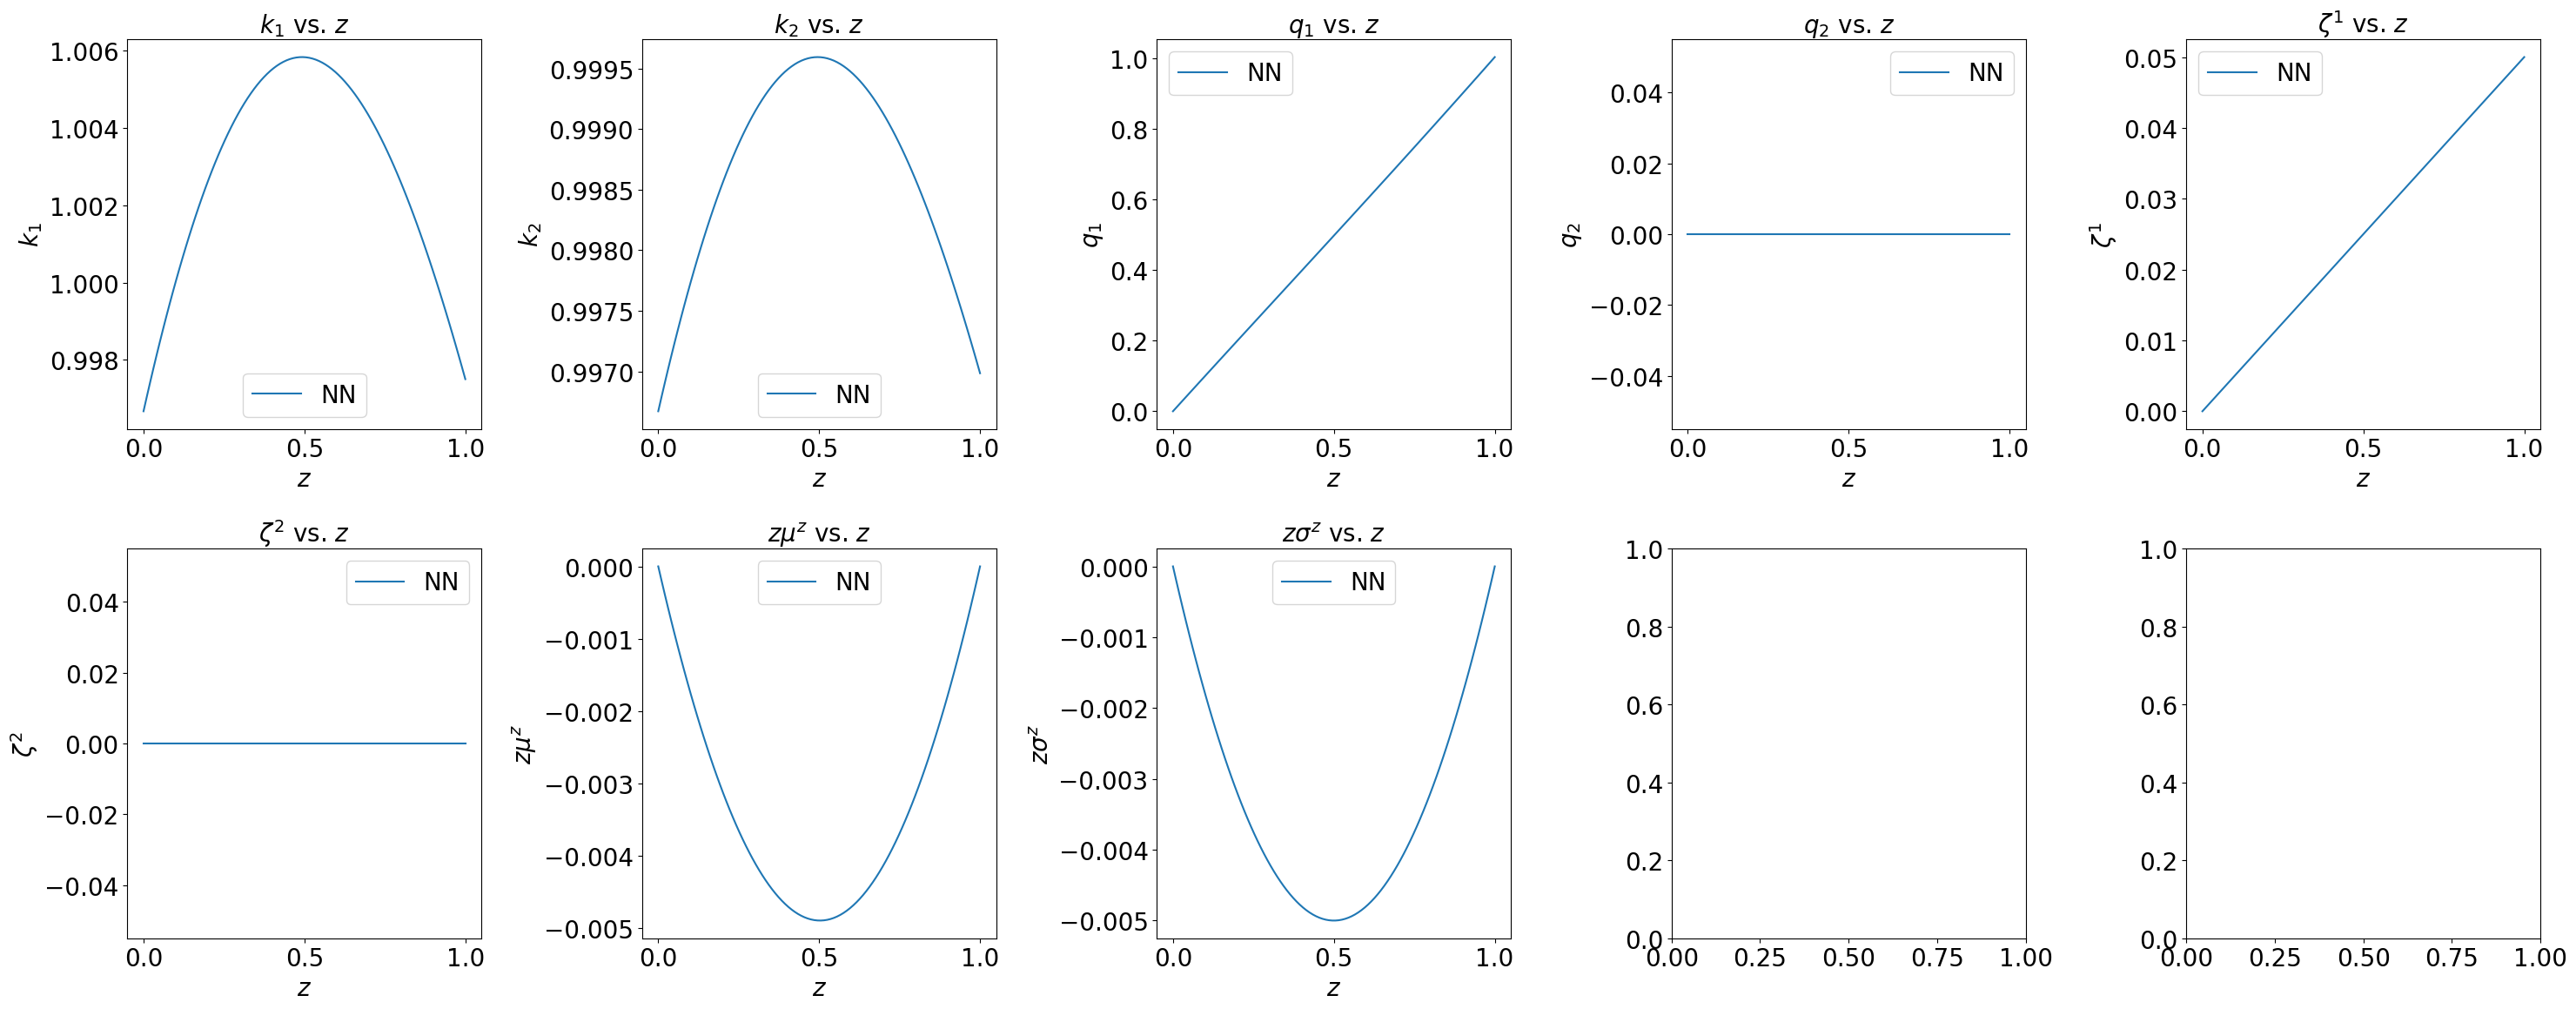

In [6]:
SV = torch.zeros((100, 3), device=model.device)
SV[:, 0] = torch.linspace(0.0, 1.0, 100, device=model.device)
SV[:, 1] = 0.0
SV.requires_grad_(True)
for i, sv_name in enumerate(model.state_variables):
    model.variable_val_dict[sv_name] = SV[:, i:i+1]
model.variable_val_dict["SV"] = SV
model.update_variables(SV)
ks_nn = model.variable_val_dict["k"].detach().cpu().numpy()
qs_nn = model.variable_val_dict["q"].detach().cpu().numpy()
zetas_nn = model.variable_val_dict["zetas"].detach().cpu().numpy()
muzari_nn = model.variable_val_dict["mu_z_aris"].detach().cpu().numpy()
sigzari_nn = model.variable_val_dict["sig_z_aris"].detach().cpu().numpy()

x_plot = SV[:, 0].detach().cpu().numpy()

xlabel = "$z$"
plot_args = [
    {"y": ks_nn[:, 0], "ylabel": r"$k_1$", "title": r"$k_1$ vs. $z$"},
    {"y": ks_nn[:, 1], "ylabel": r"$k_2$", "title": r"$k_2$ vs. $z$"},
    {"y": qs_nn[:, 0], "ylabel": r"$q_1$", "title": r"$q_1$ vs. $z$"},
    {"y": qs_nn[:, 1], "ylabel": r"$q_2$", "title": r"$q_2$ vs. $z$"},
    {"y": zetas_nn[:, 0], "ylabel": r"$\zeta^1$", "title": r"$\zeta^1$ vs. $z$"},
    {"y": zetas_nn[:, 1], "ylabel": r"$\zeta^2$", "title": r"$\zeta^2$ vs. $z$"},
    {"y": muzari_nn[:, 0], "ylabel": r"$z\mu^z$", "title": r"$z\mu^z$ vs. $z$"},
    {"y": sigzari_nn[:, 0], "ylabel": r"$z\sigma^z$", "title": r"$z\sigma^z$ vs. $z$"},
]

plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(2, 5, figsize=(30, 12))
for i, plot_arg in enumerate(plot_args):
    row = i // 5
    col = i % 5
    curr_ax = ax[row, col]
    curr_ax.plot(x_plot, plot_arg["y"], label="NN")
    curr_ax.set_xlabel(xlabel)
    curr_ax.set_ylabel(plot_arg["ylabel"])
    curr_ax.set_title(plot_arg["title"], fontsize=20)
    curr_ax.legend()
plt.tight_layout()
plt.show()

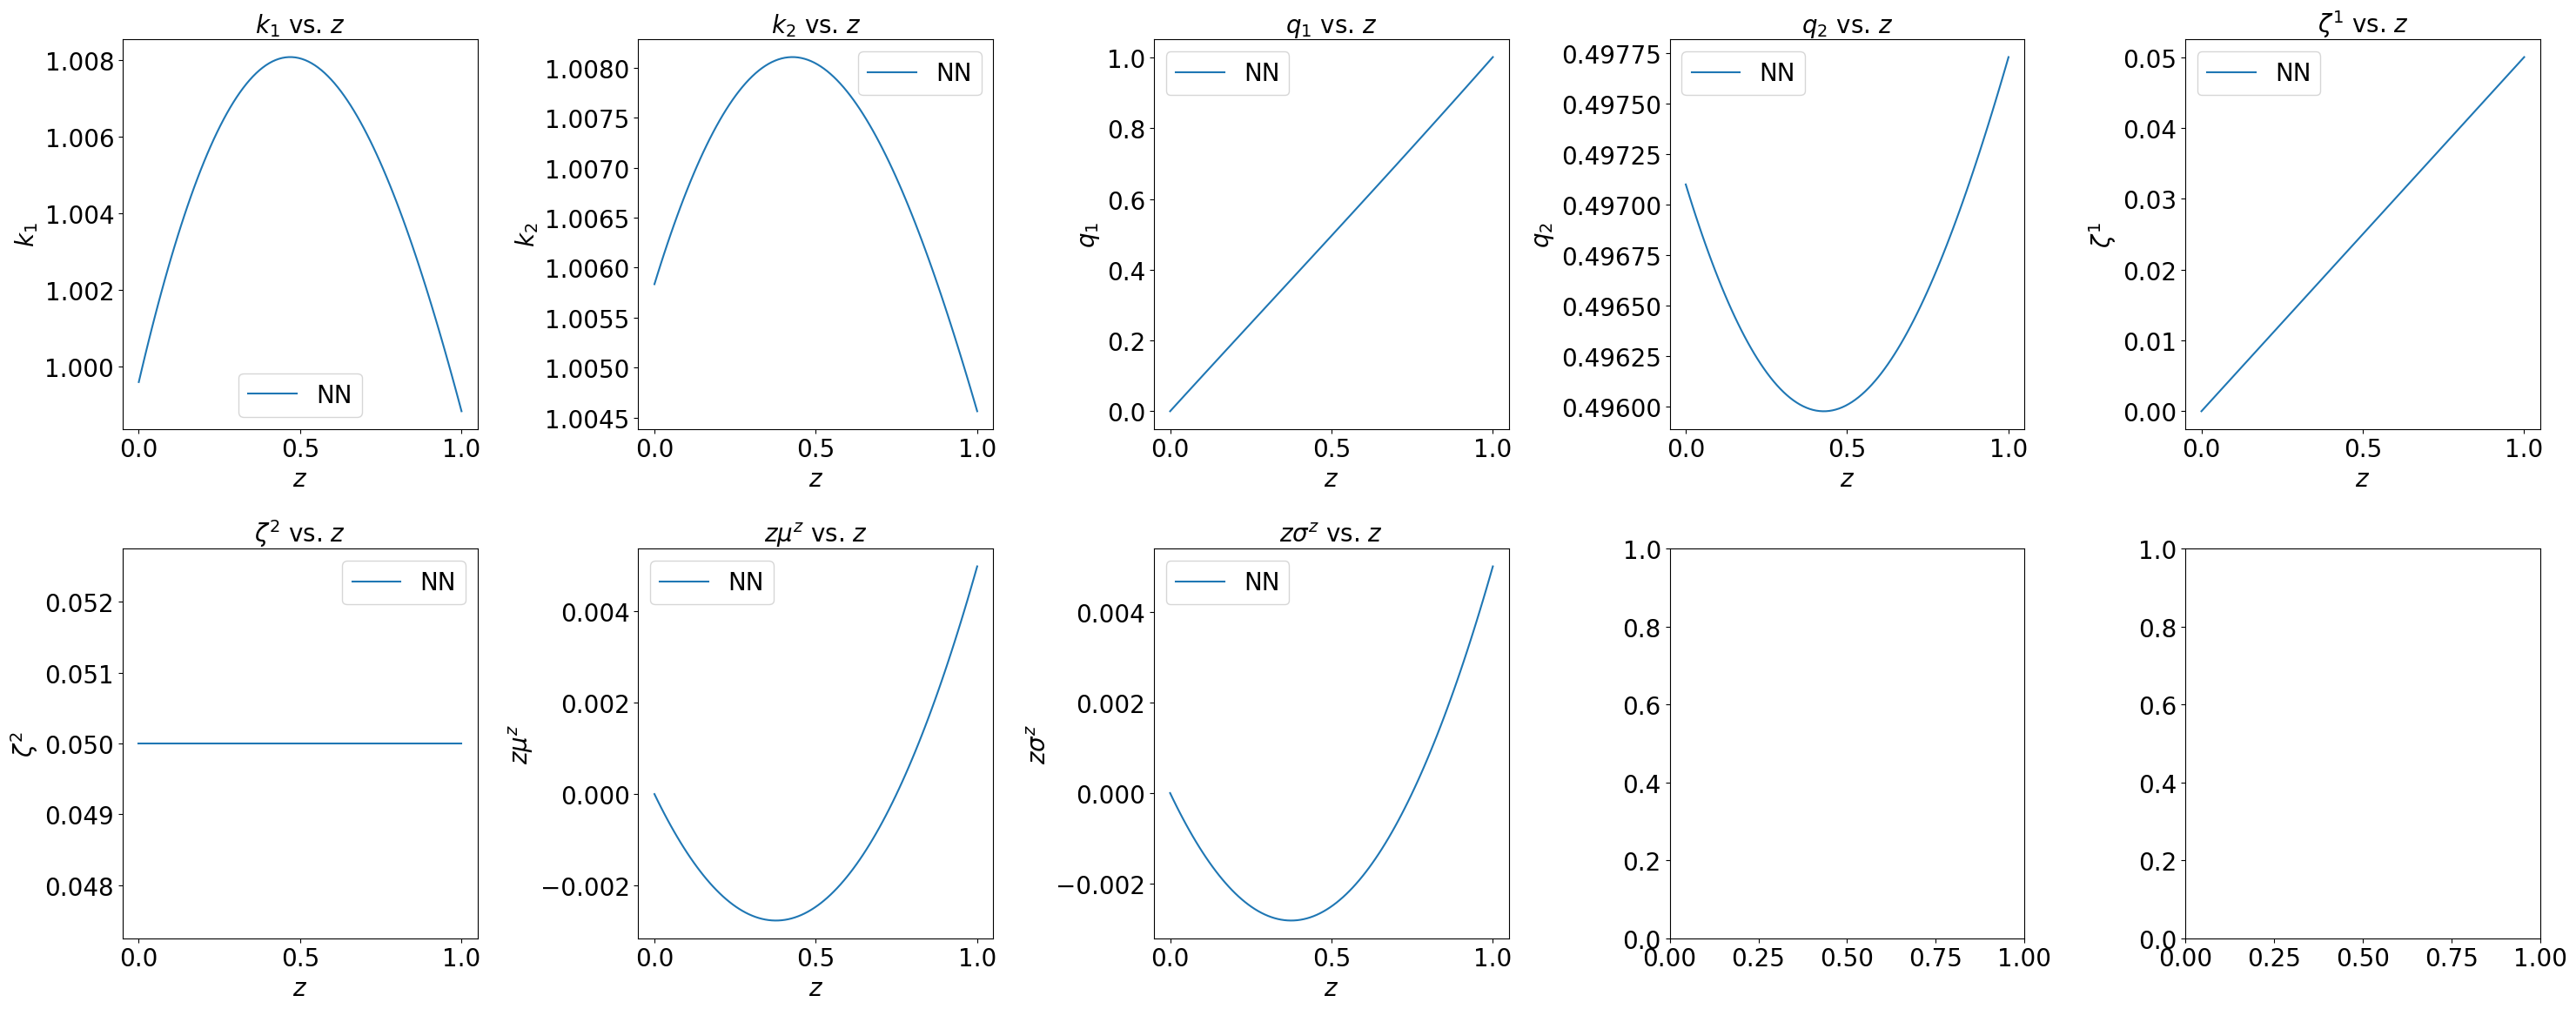

In [7]:
SV = torch.zeros((100, 3), device=model.device)
SV[:, 0] = torch.linspace(0.0, 1.0, 100, device=model.device)
SV[:, 1] = 0.5
SV.requires_grad_(True)
for i, sv_name in enumerate(model.state_variables):
    model.variable_val_dict[sv_name] = SV[:, i:i+1]
model.variable_val_dict["SV"] = SV
model.update_variables(SV)
ks_nn = model.variable_val_dict["k"].detach().cpu().numpy()
qs_nn = model.variable_val_dict["q"].detach().cpu().numpy()
zetas_nn = model.variable_val_dict["zetas"].detach().cpu().numpy()
muzari_nn = model.variable_val_dict["mu_z_aris"].detach().cpu().numpy()
sigzari_nn = model.variable_val_dict["sig_z_aris"].detach().cpu().numpy()

x_plot = SV[:, 0].detach().cpu().numpy()

xlabel = "$z$"
plot_args = [
    {"y": ks_nn[:, 0], "ylabel": r"$k_1$", "title": r"$k_1$ vs. $z$"},
    {"y": ks_nn[:, 1], "ylabel": r"$k_2$", "title": r"$k_2$ vs. $z$"},
    {"y": qs_nn[:, 0], "ylabel": r"$q_1$", "title": r"$q_1$ vs. $z$"},
    {"y": qs_nn[:, 1], "ylabel": r"$q_2$", "title": r"$q_2$ vs. $z$"},
    {"y": zetas_nn[:, 0], "ylabel": r"$\zeta^1$", "title": r"$\zeta^1$ vs. $z$"},
    {"y": zetas_nn[:, 1], "ylabel": r"$\zeta^2$", "title": r"$\zeta^2$ vs. $z$"},
    {"y": muzari_nn[:, 0], "ylabel": r"$z\mu^z$", "title": r"$z\mu^z$ vs. $z$"},
    {"y": sigzari_nn[:, 0], "ylabel": r"$z\sigma^z$", "title": r"$z\sigma^z$ vs. $z$"},
]

plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(2, 5, figsize=(30, 12))
for i, plot_arg in enumerate(plot_args):
    row = i // 5
    col = i % 5
    curr_ax = ax[row, col]
    curr_ax.plot(x_plot, plot_arg["y"], label="NN")
    curr_ax.set_xlabel(xlabel)
    curr_ax.set_ylabel(plot_arg["ylabel"])
    curr_ax.set_title(plot_arg["title"], fontsize=20)
    curr_ax.legend()
plt.tight_layout()
plt.show()